In [1]:
from helper import *
from tqdm import tqdm

In [2]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_precision_recall_curve, recall_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA

In [3]:
answers = read_json('../data/kg/answers.json')
questions = list(answers.keys())
questions_train, questions_test = train_test_split(questions, random_state = 0)
data = []
positives = 0
for q in tqdm(questions_train):
    q_len = len(find_keywords(q))
    for sentence in answers[q]:
        positives += sentence['isCorrect']
        row = [sentence['sent_stemmed_overlap'], sentence['sent_text'], sentence['sent_tokens'], sentence['nbr_text'], sentence['nbr_tokens'], sentence['topic1'], sentence['topic2'], sentence['answer_type']]
        row = list(map(lambda x: x/q_len, row))
        row.append(sentence['isCorrect'])
        data.append(row)
print(data[0])


100%|██████████| 64/64 [00:03<00:00, 19.73it/s]

[1.0, 0.0, 0.7213475204444817, 0.0, 0.7213475204444817, 1.0, 0.0, 0.0, False]


In [4]:
clf = LogisticRegression(class_weight = {0: positives, 1: len(data) - positives})
X = np.array([list(map(float, row[:-1])) for row in data])
y = np.array([int(row[-1]) for row in data])
print([i for i in y].count(1))

for train_index, test_index in KFold(n_splits = 5, shuffle = True, random_state = 0).split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    print('weights:', clf.coef_[0])
    print('accuracy:', clf.score(X_test, y_test), 'recall:', recall_score(y_test, clf.predict(X_test)))
    print()
clf.fit(X, y)
weights = clf.coef_[0]

90
weights: [1.52928221 4.84208777 1.05179532 3.18376386 1.05179532 1.63912702
 0.1497527  0.        ]
accuracy: 0.843363561417972 recall: 0.9411764705882353

weights: [1.35575607 5.48189938 1.27539785 2.96964448 1.27539785 1.05311587
 0.60230071 0.        ]
accuracy: 0.8458367683429514 recall: 0.8

weights: [1.75551228 5.4039375  1.06211018 2.49036139 1.06211018 1.55761712
 0.31066662 0.        ]
accuracy: 0.8507831821929102 recall: 0.7647058823529411

weights: [1.9269483  6.61609571 1.16109378 1.81343825 1.16109378 1.67796708
 0.00940152 0.        ]
accuracy: 0.8613861386138614 recall: 0.6842105263157895

weights: [2.20367604 5.85424218 1.00845481 2.70141555 1.00845481 1.54443818
 0.48805435 0.        ]
accuracy: 0.844059405940594 recall: 0.7647058823529411



  9%|▉         | 2/22 [00:00<00:01, 11.50it/s]

weights: [1.77087296 5.50115097 1.10609963 2.70381795 1.10609963 1.51921344
 0.31516321 0.        ]


100%|██████████| 22/22 [00:01<00:00, 18.66it/s]


[10, 14, 14, 14, 15, 15, 15, 17, 19, 19, 19, 19, 19, 19, 19] 22


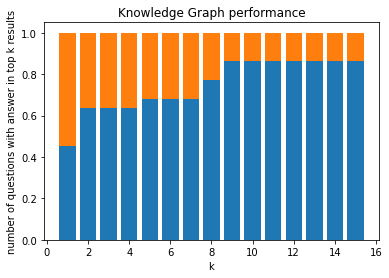

In [10]:
print('weights:', weights)
k = 15
top_k = [0 for i in range(k)]
for q in tqdm(questions_test):
    q_len = len(find_keywords(q))
    ranks = []
    for sentence in answers[q]:
        positives += sentence['isCorrect']
        row = [sentence['sent_stemmed_overlap'], sentence['sent_text'], sentence['sent_tokens'], sentence['nbr_text'], sentence['nbr_tokens'], sentence['topic1'], sentence['topic2'], sentence['answer_type']]
        row = list(map(lambda x: x/q_len, row))
        score = [row[i] * weights[i] for i in range(len(row))]
        ranks.append((score, sentence['isCorrect']))
    ranks.sort(reverse = True)
    ranks = ranks[:k]
    found = False
    for i in range(k):
        if i < len(ranks) and ranks[i][1]:
            found = True
        if found:
            top_k[i] += 1
print(top_k, len(questions_test))
top_k = list(map(lambda x: x/len(questions_test), top_k))
import matplotlib.pyplot as plt
plt.bar(range(1, k + 1),top_k)
plt.bar(range(1, k + 1), list(map(lambda x: 1 - x, top_k)), bottom = top_k)
plt.xlabel('k')
plt.ylabel('number of questions with answer in top k results')
plt.title('Knowledge Graph performance')
plt.savefig('../data/kg/performance')
plt.show()